# Sound synchronization
This notebook will test the synchronization between the sound capture (via `jack_capture`) and GPIO values via system timestamps.

## Experimental overview
To test the synchronization, we sent pulses from a GPIO pin on the board to the line or mic input on the sound card. (If using a card with only one input port, be sure that it's switched to `line` in the software unless you use a specific line-to-mic adapter circuit!)

## Initial setup

### Imports

In [3]:
import wave
from scipy.io import wavfile
from scipy.signal import butter, lfilter, freqz, hilbert
from scipy import fft, ifft
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

### Functions

In [463]:
# From: https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html
def butter_design(*freq, btype='band', fs=1.0, order=5):
    nyq = 0.5 * fs
    freq = [f/nyq for f in freq]
    b, a = butter(order, freq, btype=btype)
    return b, a

def butter_filter(data, *freq, btype='band', fs=1.0, order=5):
    b, a = butter_design(*freq, btype=btype, fs=fs, order=order)
    y = lfilter(b, a, data)
    return y

def get_times_from_signal(s, thresh, edge='rising', fs=1.0, dt_min=None):
    # Find ON component of signal
    gt_thresh = (s > thresh).astype(np.int16)
    
    if edge.lower() == 'rising':
        # Find crossings on rising edge
        t = np.argwhere((gt_thresh - np.roll(gt_thresh, -1)) == -1).flatten() + 1
        if (gt_thresh[-1] == 0) and (gt_thresh[0] == 1):
            # Correct wrap-around error
            t = t[:-1]
        if (np.sum(gt_thresh[:2]) == 2):
            # Correct first data point
            t = np.insert(t, 0, 0.0)
    elif edge.lower() == 'falling':
        # Find crossings on rising edge
        t = np.argwhere((gt_thresh - np.roll(gt_thresh, -1)) == 1).flatten()
        if (gt_thresh[-1] == 1) and (gt_thresh[0] == 0):
            # Correct wrap-around error
            t = t[:-1]
    else:
        raise ValueError('Edge type must be \'rising\' or \'falling\'.')

    # Convert to timestamps
    t = t/fs
    
    # Filter by minimum interevent time if specified
    if dt_min is not None:
        t = filter_by_interevent_times(t, dt_min)
    
    return t
    
def filter_by_interevent_times(t, dt_min, max_iters=10):
    for i in range(max_iters):
        # Get indices of below-threshold interevent times
        idx = np.diff(t) < dt_min
        idx = np.logical_or(np.insert(idx, 0, False),
                            np.insert(idx, -1, False))

        # Get bounds of these indices
        idx_start = get_times_from_signal(idx.astype(np.int64),
                                      thresh=0.5,
                                      edge='rising',
                                      fs=1.0).astype(np.int64)
        idx_stop = get_times_from_signal(idx.astype(np.int64),
                                          thresh=0.5,
                                          edge='falling',
                                          fs=1.0).astype(np.int64)
        if len(idx_stop) < len(idx_start):
            idx_stop =  np.append(idx_stop, len(idx) - 1)

        # Find short interevent times relative to starting point
        t_rel = np.repeat(t[idx_start], idx_stop - idx_start + 1)
        dt = np.cumsum(np.diff(t[idx] - t_rel))

        # Get indices of event times that exceed dt_min from starting point
        idx_keep = np.logical_or(dt >= dt_min, dt == 0)
        idx_keep = np.insert(idx_keep, 0, True) # keep first starting point

        # Convert these indices to be relative to initial array
        idx_keep_ = np.zeros(len(t), dtype=np.bool)
        idx_keep_[np.argwhere(idx).flatten()[idx_keep]] = True

        # Check filtered array interevent times
        t = t[np.logical_or(~idx, idx_keep_)]
        if np.sum(np.diff(t) < dt_min) == 0:
            return t
    
    raise RuntimeError('Could not filter interevent times after {} iterations.'
                       .format(max_iters))
    
# Some code from another repo
def dec_to_bin_array(d, bits=None, bit_order='<'):
    # Convert to numpy array if needed
    if not isinstance(d, np.ndarray):
        d = np.array([d])
    
    # Calculate minimum bits to represent integer
    min_bits = np.max(np.ceil(np.log2(np.maximum(d, np.ones(d.shape))))).astype(np.int64)
    if bits is None:
        bits = min_bits
    elif bits < min_bits:
        raise ValueError('Not enough bits to represent number. At least %d bits required.' % min_bits)
    
    # Broadcast binary representation to new axis at end
    b = np.zeros(list(d.shape) + [bits], dtype=np.int16)
    rem = d
    bit = bits
    while (bit > 0) and (rem > 0).any():
        bit -= 1
        b[..., bit] = (rem >= 2**bit)
        rem = rem % 2**bit
    
    # Return binary representation
    if bit_order == '<':
        return b
    elif bit_order == '>':
        return b[..., ::-1]
    else:
        raise ValueError('Unknown bit order \'%s\'' % bit_order)
        
def plot_idx(t, t_window):
    return np.logical_and(t >= t_window[0], t <= t_window[1])

## Load audio files

### Settings

In [541]:
# Filenames
input_filename = '/home/james/Desktop/audio/xonar-se/pulse-10ms-96000Hz/Microphone2-01.wav'

### Filter audio

/home/james/anaconda3/envs/behavior/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


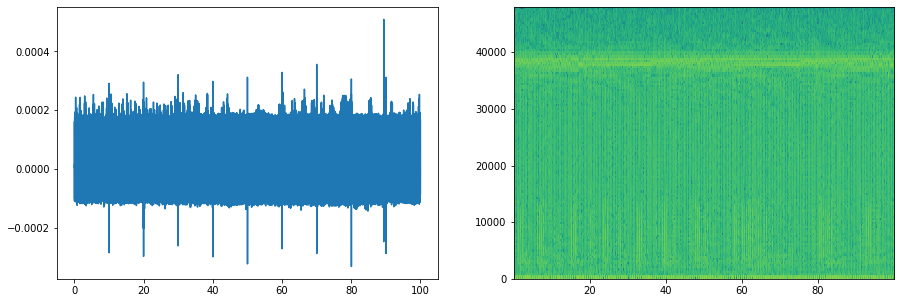

In [542]:
# Load audio files
fs, wf = wavfile.read(input_filename)
t_sc = np.arange(len(wf))/fs

# Plot waveforms
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex='col')
t_plot = [0.0, 100.0] # for easier visualization
idx = plot_idx(t_sc, t_plot)
_ = ax[0].plot(t_sc[idx], wf[idx])
#_ = ax[0].vlines(np.arange(5)*2 + 1.5, ymin=-0.00001, ymax=0.00001, 
#                 color='black', zorder=3)
_ = ax[1].specgram(wf[idx], Fs=fs, NFFT=256, Fc=0, scale='dB')

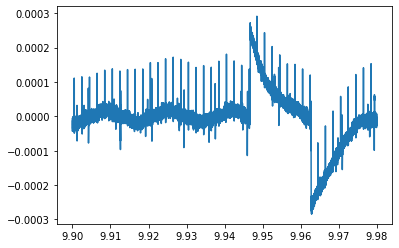

In [543]:
# Zoom in on a peak
fig, ax = plt.subplots()
t_plot = [9.90, 9.98]
idx = plot_idx(t_sc, t_plot)
_ = ax.plot(t_sc[idx], wf[idx])

We see something like an exponential decay from an RC circuit. This makes sense because the line input typically has capacitive coupling to block any DC offset present in the signal.

Let's low-pass filter to get rid of some of the noise. A cutoff around 500 Hz seems like a good choice.

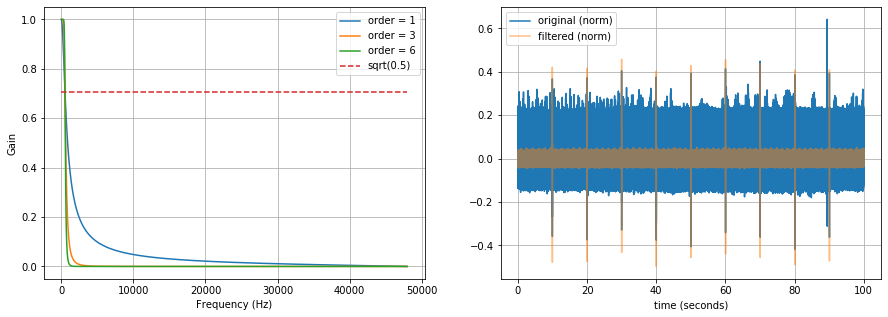

In [544]:
# From: https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
t_plot = [0.0, 100.0] # for easier viewing

# Sample rate and desired cutoff frequencies (in Hz).
highcut = 500.0
order = 5

# Plot the frequency response for a few different orders.
for order_i in [1, 3, 6]:
    b, a = butter_design(highcut, fs=fs, order=order_i, btype='low')
    w, h = freqz(b, a, worN=2000)
    ax[0].plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order_i)

ax[0].plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('Gain')
ax[0].grid(True)
ax[0].legend(loc='best')

# Filter a noisy signal.
wf_filt = butter_filter(wf, highcut, btype='low', fs=fs, order=order)

# Plot filtered signal
idx = plot_idx(t_sc, t_plot)
ax[1].plot(t_sc[idx], wf[idx]/wf.max(), label='original (norm)')
ax[1].plot(t_sc[idx], wf_filt[idx]/wf_filt.max(), label='filtered (norm)', alpha=0.5)
ax[1].set_xlabel('time (seconds)')
ax[1].grid(True)
ax[1].axis('tight')
ax[1].legend(loc='upper left');

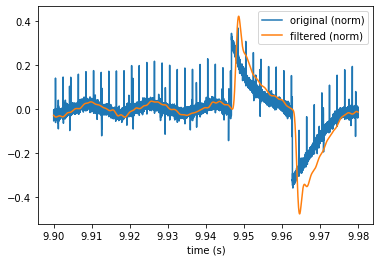

In [546]:
# Zoom in on a filtered peak
fig, ax = plt.subplots()
t_plot = [9.90, 9.98]
idx = plot_idx(t_sc, t_plot)
ax.plot(t_sc[idx], wf[idx]/wf.max(), 
        label='original (norm)')
ax.plot(t_sc[idx], wf_filt[idx]/wf_filt.max(), 
        label='filtered (norm)')
ax.set_xlabel('time (s)')
ax.legend();

### Estimate SNR
To estimate the signal-to-noise ratio, we need to estimate the power of each separately.
- **Noise**: Estimate variance of high-pass filtered audio. The power of noise drawn from $\mathcal{N} ~ (0, \sigma^2)$ is just $\sigma^2$.
- **Signal**: Estimate peak value of signal. Square to estimate power.

In [547]:
# Estimate noise
lowcut = 500.0
order = 3
noise = butter_filter(wf, lowcut, btype='high', fs=fs, order=order)

#fig, ax = plt.subplots()
#tt = np.arange(len(wf))/fs
#ax.plot(tt, wf/wf.max(), label='original (norm)')
#ax.plot(tt, noise/wf.max(), label='filtered', alpha=0.5)
#ax.set_xlabel('time (seconds)')

# Estimate variance (and mean)
mu = np.mean(noise)
sigma = np.std(noise)
print('Noise mean: {:.2e}'.format(mu))
print('Noise std:  {:.2e}'.format(sigma))

# Get signal peak
signal = wf_filt.max()
print('Signal peak: {:.2e}'.format(signal))

# Calculate SNR in dB
SNR = 10*np.log10(signal**2/sigma**2)
print('SNR (dB): {:.2f}'.format(SNR))

Noise mean: -4.79e-16
Noise std:  1.93e-05
Signal peak: 5.73e-04
SNR (dB): 29.44


## Synchronization

### Extract audio pulse times
We will start by looking at time points at which the voltage signal crosses some threshold value (say, fraction of maximum value). On the *rising* edge of a square wave, the processed line-in signal will look like a (positive) exponential decay; in other words, an exponential decay with an impulse response at the particular time stamps. We could likewise look at the initial crossing of a negative threshold value for the *falling* portion of the square wave, as it should simply be reflection across the y-axis.

In [553]:
# Threshold
thresh = 0.25*wf_filt.max() # signal threshold
dt_min = 9.0 # minimum inter-pulse interval (s)

# Timestamps
t_pulse_sc = get_times_from_signal(wf_filt, thresh, fs=fs, dt_min=dt_min)

print('Found {} pulses ({:.3e} Hz).'
      .format(len(t_pulse_sc), len(t_pulse_sc)/(len(wf_filt)/fs)))

Found 359 pulses (9.968e-02 Hz).


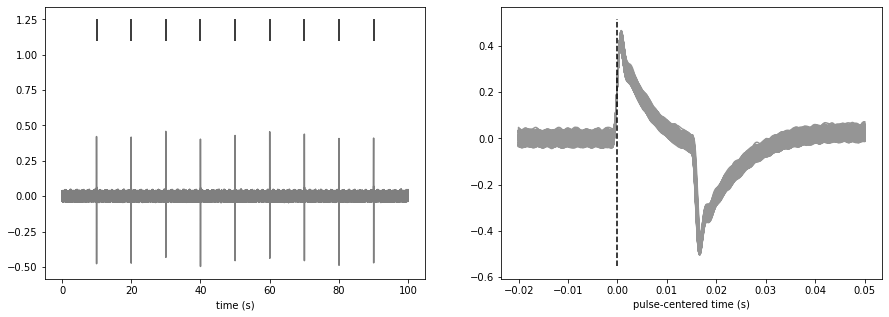

In [549]:
# Plot results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
t_plot = [0.0, 100.0] # for easier viewing

# Plot overall timestamps
idx = plot_idx(t_sc, t_plot)
ax[0].plot(t_sc[idx], wf_filt[idx]/wf_filt.max(), color='black', alpha=0.5)
idx = plot_idx(t_pulse_sc, t_plot)
ax[0].vlines(t_pulse_sc[idx], ymin=1.1, ymax=1.25, color='black')
ax[0].set_xlabel('time (s)')

# Plot traces
t_window = [-0.020, 0.050]
cmap = plt.get_cmap('Greys')
for i, t in enumerate(t_pulse_sc):
    # Zoom in on a filtered peak
    t_window_i = [t + t_i for t_i in t_window]
    #t1 = t + t_window[0]
    #t2 = t + t_window[1]
    #tt = np.arange(int(t1*fs), int(t2*fs))/fs - t
    idx = plot_idx(t_sc, t_window_i)
    ax[1].plot(t_sc[idx] - t, 
               wf_filt[idx]/wf_filt.max(), 
               color=cmap(0.50))

# Plot peak detect time
ylim = ax[1].get_ylim()
ax[1].plot([0.0, 0.0], [ylim[0], ylim[1]], color='black', linestyle='--')
ax[1].set_xlabel('pulse-centered time (s)');    

### Extract GPIO pulse times

In [554]:
# Log filename
log_filename = '/home/james/Desktop/audio/xonar-se/pulse-10ms-96000Hz/Log2020-04-21 1250.txt'

In [555]:
# Load log data
with open(log_filename, 'r') as f:
    log = np.loadtxt(log_filename, delimiter=',', comments='<')

# Get board timestamps
t_pcb_rt = log[:, -1] # realtime clock
t_pcb_mt = log[:, -2] # monotonic clock

# Get pulse values
pin = 0
gpio = dec_to_bin_array(log[:, 1])
pin_on = gpio[:, pin]

# Threshold
thresh = 0.5*pin_on.max()

# Get pulse timestamps
idx_pcb = get_times_from_signal(pin_on, 
                                thresh, 
                                edge='rising', 
                                fs=1.0).astype(np.int64)
t_pulse_rt = t_pcb_rt[idx_pcb] # CLOCK REALTIME
t_pulse_mt = t_pcb_mt[idx_pcb] # CLOCK MONOTONIC

### Compare pulse times
Let's look at the difference between pulse times calculated on the sound input vs. board input.

In [556]:
# Clean up sound card timestamps if needed
assert len(t_pulse_sc) == len(t_pulse_mt) == len(t_pulse_rt)

In [557]:
# Get inital jack_capture timestamps
with open(input_filename + '.tme', 'r') as f:
    rt_start = float(f.readline().strip()) # realtime clock
    mt_start = float(f.readline().strip()) # monotonic clock
    
# Subtract start time from PCB times
t_pcb_rt -= rt_start
t_pulse_rt -= rt_start
t_pcb_mt -= mt_start
t_pulse_mt -= mt_start

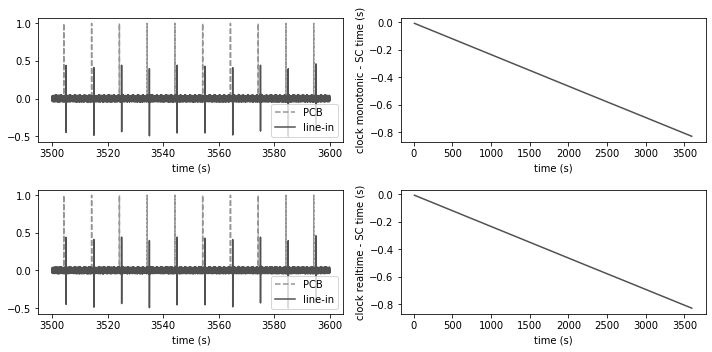

In [576]:
# Compare signals
fig, ax = plt.subplots(2, 2, figsize=(10, 5))

# Plot GPIO vs.line-in signal
iters = zip([t_pcb_mt, t_pcb_rt], [t_pulse_mt, t_pulse_rt])
for i, (t_pcb, t_pulse) in enumerate(iters):
    t_plot = [3500.0, 3600.0]
    idx = plot_idx(t_pcb, t_plot)
    ax[i, 0].plot(t_pcb[idx],
               pin_on[idx],
               color=cmap(0.50),
               linestyle='--',
               label='PCB')
    idx = plot_idx(t_sc, t_plot)
    ax[i, 0].plot(t_sc[idx], 
               wf_filt[idx]/wf_filt.max(),
               color=cmap(0.75),
               label='line-in')
    ax[i, 0].set_xlabel('time (s)')
    ax[i, 0].legend(loc='lower right')

    # Compare timestamps
    ax[i, 1].plot(t_pulse_sc,
               t_pulse - t_pulse_sc,
               color=cmap(0.75))
    ax[i, 1].set_xlabel('time (s)')

ax[0, 1].set_ylabel('clock monotonic - SC time (s)')
ax[1, 1].set_ylabel('clock realtime - SC time (s)')
plt.tight_layout()

plt.savefig('/home/james/Desktop/audio/xonar-se/pulse-10ms-96000Hz/time_diff.pdf')